## Create Custom Filters in Python

Noise is integrated into signals in different ways based on the individual recording setup. To effectively filter out this noise, custom filters can be created and tested in this notebook. This notebook is able to filter additive, multiplicative, and convolutive noise.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from spikeinterface import extractors, preprocessing
import random

Load in example file

This is taken from our GBM-organoid recording dataset. On this file is one-minute of raw recording data from 4 organoids being recorded simultaneously with 32-channel MEAs.

In [2]:
def get_recording(files, file_dir=None, save_dir=None):

    # Get Traces
    if save_dir:
        recording_dir = os.path.join(save_dir, "recording.pkl")
        if os.path.exists(recording_dir):

            recording = si.load_extractor(recording_dir)
            return recording

    if file_dir is None:
        file_dir = ""

    stream_name = "RHD2000 amplifier channel"
    recording = None
    for file in [os.path.join(file_dir, f) for f in files]:
        print(f"Processing {file}.")
        if not recording:
            recording = si.extractors.read_intan(file, stream_name=stream_name)
        else:
            recording = si.concatenate_recordings(
                [recording, si.extractors.read_intan(file, stream_name=stream_name)]
        )

    if save_dir is not None:
        recording.dump_to_pickle(file_path = os.path.join(save_dir, "recording.pkl"))

    return recording

In [4]:
file_name = "processed_O9-12_230503_204249.rhd"
file_dir = os.getcwd().replace("create_custom_filters", "example_data")

raw_recording = get_recording([file_name], file_dir=file_dir)
raw_recording

Processing c:\Users\Organoid PC\Documents\GitHub\academic_coding_projects\example_data\processed_O9-12_230503_204249.rhd.


IntanRecordingExtractor: 128 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                         60.00s (1.00 minutes) - uint16 dtype - 292.97 MiB
  file_path: C:\Users\Organoid PC\Documents\GitHub\academic_coding_projects\example_data\processed_O9-12_230503_204249.rhd

In [ ]:
# Filter recording (standard recording in DataJoint Pipeline)
recording_f = si.preprocessing.bandpass_filter(
    recording=raw_recording, freq_min=300, freq_max=4500
)
recording_filt = si.preprocessing.common_reference(
    recording=recording_f, operator="median"
)

In [ ]:
# Define necessary paramters
fs = raw_recording.get_sampling_frequency()
dt = 1/fs
N = raw_recording.get_num_frames()
t = np.arange(0, N*dt, dt)
f = np.fft.fftshift(np.fft.fftfreq(N, dt))

# extract one channel for testing
channel_id = "B-008" # see recording.get_channel_ids()


Apply additive, multiplicative, and convolutive filters to the raw recording data to see how each filter affects the signal.

In [ ]:
def plot_traces(x , yvalues , labels , windowsize=100000 , title=None):

    fig , ax = plt.subplots(2,1)
    plt.subplots_adjust(hspace=.5)
    fig.set_figwidth(7)
    fig.set_figheight(5)
    
    if title is not None:
        ax[0].suptitle = title

    ax[0].set_title("Traces")
    for idx , y in enumerate(yvalues):
        ax[0].plot(x , y , label=labels[idx])

    
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Voltage")
    ax[0].legend(loc="upper right")

    ax[1].set_title(f"Traces (random {windowsize/20000}s)")

    random_time = random.randint(0 , len(x)-windowsize)
    random_interval = [random_time , int(random_time+windowsize)]
    for idx , y in enumerate(yvalues):
        ax[1].plot(x[random_interval[0]:random_interval[1]] , y[random_interval[0]:random_interval[1]] , label=labels[idx])


    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Voltage")
    
def plot_frequency_spectrum(f , Yvalues , labels , title=None):

    plt.figure()
    if title is not None:
        plt.title(title)

    for idx , Y in enumerate(Yvalues):  
        plt.plot(f[f>=0] , abs(Y[f>=0]) , label=labels[idx])


    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="lower left")

def filter_additive_noise(f , x , fbands , inverse=False):

    minval = np.finfo(np.float32).eps

    # If noise is additive
    X = np.fft.fftshift(np.fft.fft(x)) # X = frequency domain of x , fftshift shifts the plot so it's centered at 0 Hz

    Xfilter = np.ones(len(x)) * minval
    for fband in fbands:
        Xfilter[(abs(f) >= fband[0]) & (abs(f) <= fband[1])] = 1

    if inverse:
        Xfilter = -Xfilter + 1

    X_filt = X * Xfilter

    x_filt = np.fft.ifft(np.fft.ifftshift(X_filt))
    x_filt = np.real(x_filt)

    return x_filt , X_filt

def filter_multiplicative_noise(f , x , fbands , inverse=False):

    minval = np.finfo(np.float32).eps
    
    x[x==0] = minval # log can't divide by 0
    lnx = np.log(x.astype(complex)) # now log can deal with negatives

    lnX = np.fft.fftshift(np.fft.fft(lnx)) # DFT

    Xfilter = np.ones(len(x)) * minval
    for fband in fbands:
        Xfilter[(abs(f)>=fband[0]) & (abs(f)<=fband[1])] = 1

    if inverse:
        Xfilter = -Xfilter + 1

    lnX_filt = lnX * Xfilter

    lnx_filt = np.fft.ifft(np.fft.ifftshift(lnX_filt)) # bring back to time domain
    x_filt = np.real(np.exp(lnx_filt)) # undo log

    # find frequency spectra values
    X_filt = np.fft.fftshift(np.fft.fft(x_filt))

    return x_filt , X_filt , lnX , lnX_filt

def filter_convolved_noise(f , x , fbands , inverse=False):

    minval = np.finfo(np.float32).eps
    
    # Check if noise is convoluted
    # DFT
    X = np.fft.fft(x) 
    # Unwrap
    X_mag = np.abs(X)
    X_phase = np.angle(X)
    # Log
    X_mag[X_mag==0] = minval
    lnX_mag = np.log(X_mag)
    # Inverse Fourier
    xq = np.fft.fftshift(np.fft.ifft(lnX_mag))
    # Filter (trial and error)
    Qfilter = np.ones(len(x)) * minval
    for fband in fbands:
        Qfilter[(abs(f)>=fband[0]) & (abs(f)<=fband[1])] = 1

    if inverse:
        Qfilter = -Qfilter + 1
    xq_filt = xq * Qfilter

    # Start to invert everything and get filtered single
    # DFT
    Xq_filt = np.fft.fft(np.fft.ifftshift(xq_filt))
    # Inverse Log --> exp
    Xfilt_mag = np.abs(np.exp(Xq_filt)) # Idk if abs is needed
    # Rewrap phase
    Xfilt = Xfilt_mag * np.exp(1j * X_phase)
    # Inverse Fouerier
    x_filt = np.real(np.fft.ifft(Xfilt))
    # Get frequency spectra
    X_filt = np.fft.fftshift(np.fft.fft(x_filt))

    return x_filt , X_filt, xq , xq_filt

In [ ]:
# get trace
x = raw_recording.get_traces(return_scaled=True, channel_ids=[channel_id]).squeeze()
X = np.fft.fftshift(np.fft.fft(x))

# standard filtered trace
x_si_filt = recording_filt.get_traces(return_scaled=True, channel_ids=[channel_id]).squeeze()
X_si_filt = np.fft.fftshift(np.fft.fft(x_si_filt))

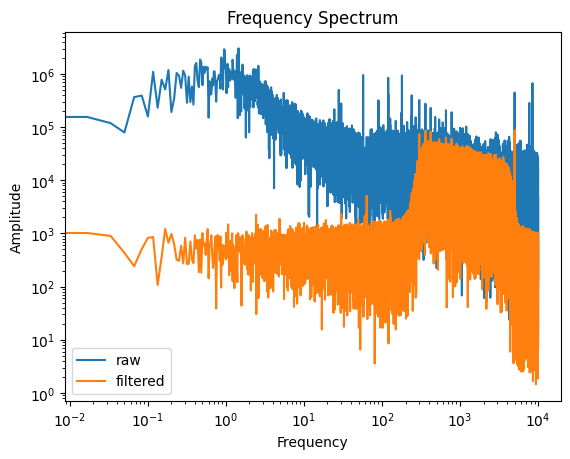

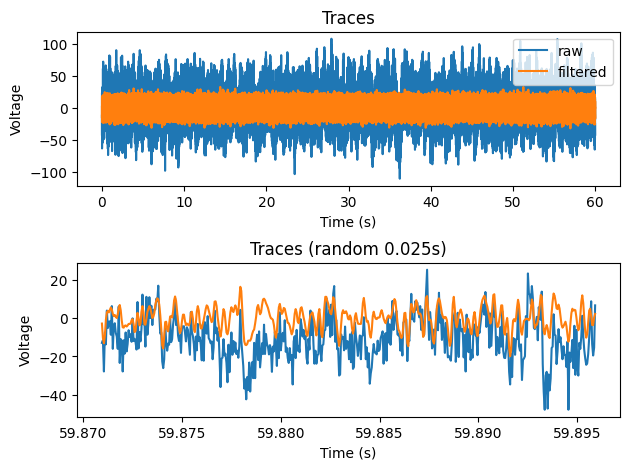

In [ ]:
# Plot Traces and Spike Interface Filters

plot_frequency_spectrum(f , [X,X_si_filt] , ["raw","filtered"] , title="Frequency Spectrum")

plot_traces(t , [x , x_si_filt] , ["raw" , "filtered"] , windowsize=500)


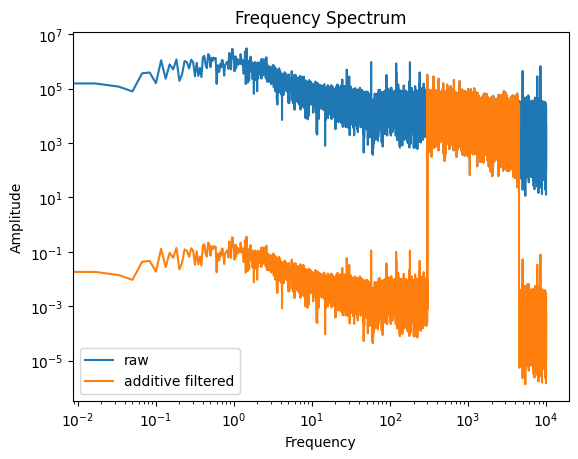

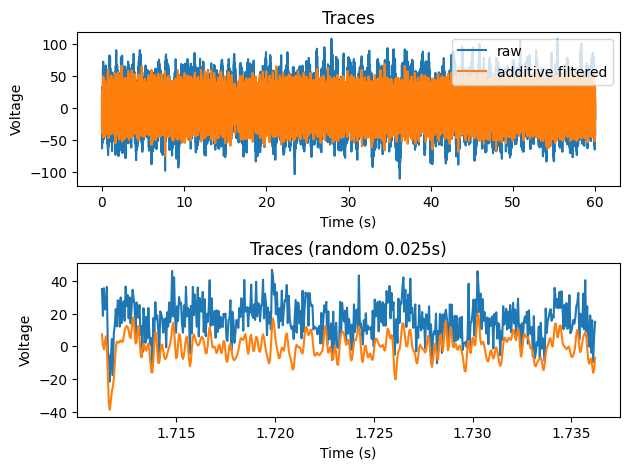

In [ ]:
# Filter for Additive Noise
x_afilt , X_afilt = filter_additive_noise(f , x , [[300 , 4500]])

plot_frequency_spectrum(f=f , Yvalues=[X,X_afilt] , labels=["raw" , "additive filtered"] , title="Frequency Spectrum")

norm = np.mean(abs(x))/np.mean(abs(x_afilt))
plot_traces(t , [x,x_afilt] , labels=["raw" , "additive filtered"] , windowsize=500)



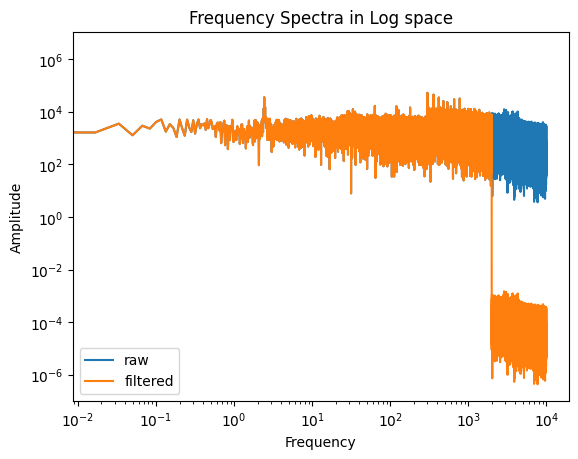

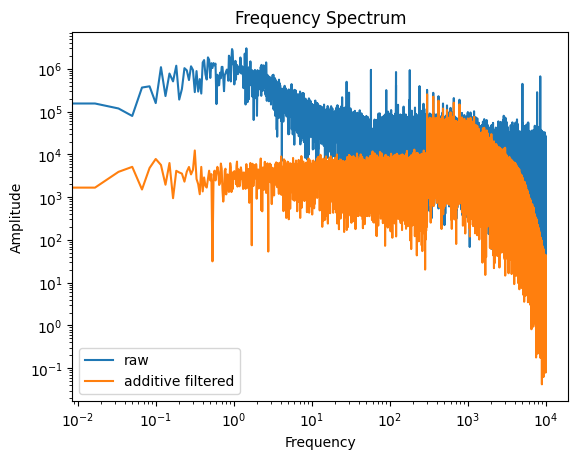

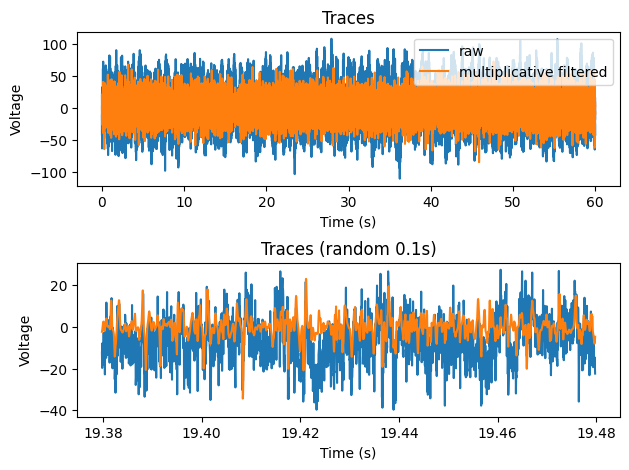

In [ ]:
x_afilt2 , X_afilt2 , lnX , lnX_filt = filter_multiplicative_noise(f , x_afilt , [[0 , 2000]])


plot_frequency_spectrum(f , [lnX,lnX_filt] , labels = ["raw","filtered"] , title="Frequency Spectra in Log space")
plot_frequency_spectrum(f=f , Yvalues=[X,X_afilt2] , labels=["raw" , "additive filtered"] , title="Frequency Spectrum")

norm = np.mean(abs(x))/np.mean(abs(x_afilt2))
plot_traces(t , [x,x_afilt2] , labels=["raw","multiplicative filtered"] , windowsize=2000)

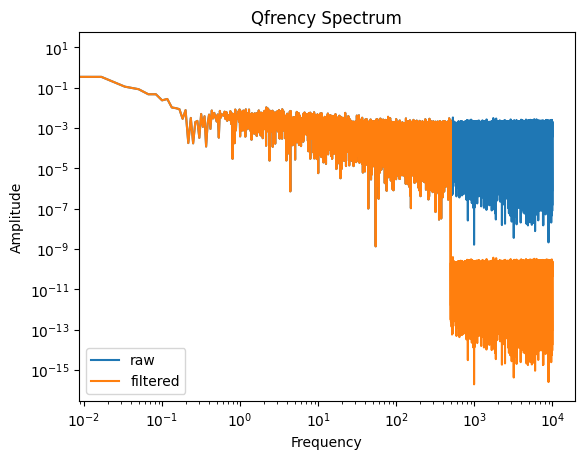

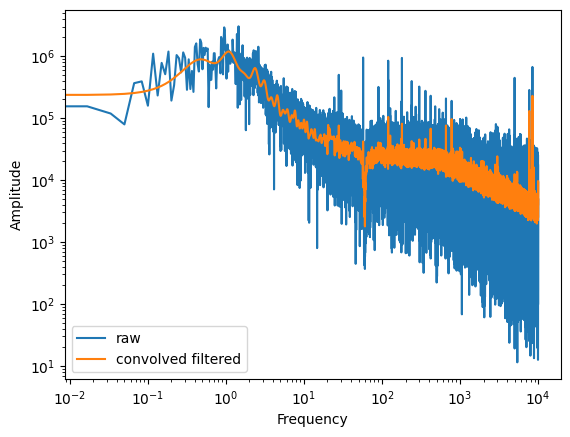

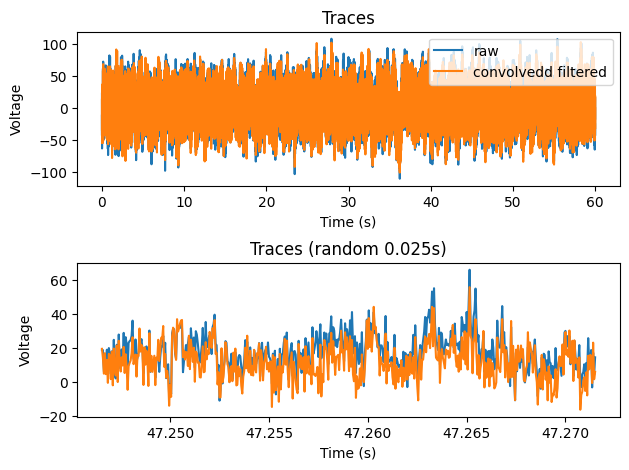

In [ ]:
# Filter for Convolved Noise
x_cfilt , X_cfilt , xq , xq_filt = filter_convolved_noise(f , x , [[0,500]])

plot_frequency_spectrum(f , [xq,xq_filt] , labels=["raw","filtered"] , title="Qfrency Spectrum")
plot_frequency_spectrum(f , [X,X_cfilt] , labels=["raw","convolved filtered"])

norm = np.mean(abs(x))/np.mean(abs(x_cfilt))
plot_traces(t , [x,x_cfilt*norm] , labels=["raw","convolvedd filtered"] , windowsize=500)



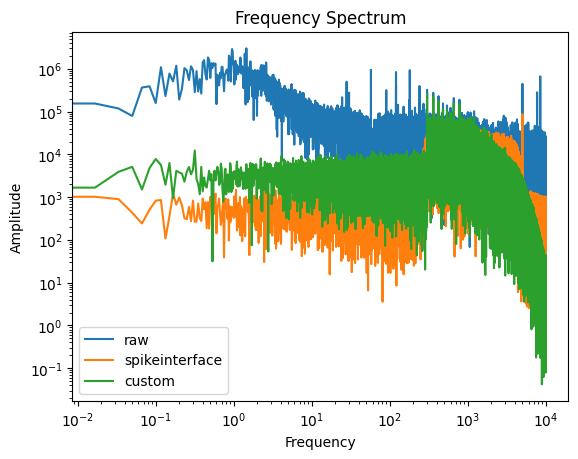

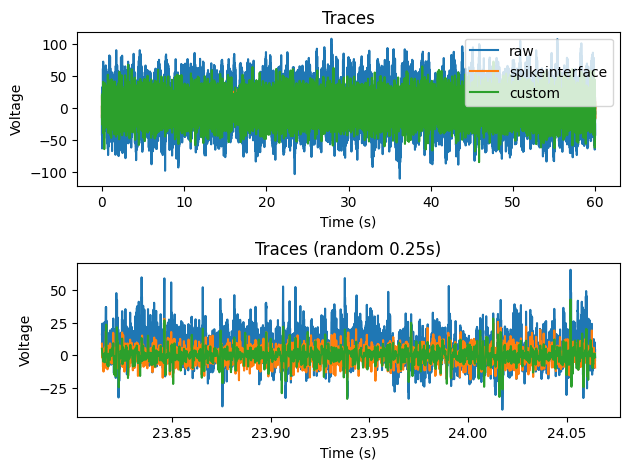

In [ ]:
# Add Custom Filter

x1 , X1 = filter_additive_noise(f , x , [[300,4500]])
x2 , X2 , _ , _ = filter_multiplicative_noise(f , x1 , [[0,2000]])

x_filt = x2
X_filt = X2

norm = np.mean(abs(x))/np.mean(abs(x_filt))
plot_frequency_spectrum(f=f , Yvalues=[X,X_si_filt,X_filt] , labels=["raw","spikeinterface","custom"] , title="Frequency Spectrum")
plot_traces(t , [x,x_si_filt,x_filt] , labels=["raw","spikeinterface","custom"] , windowsize=5000)



